1) Convolution: a simple mathematical function that quantifies the similarity between a pattern (a "kernel") such as the red square wave below with data (the blue rectangularish thingy below). The convolution (black line) reflects how similar the blue signal is with the kernel at any given time point. Convolution is thus used in all of digital signal processing. 

![convolution](Convolution_of_spiky_function_with_box2.gif)

The math is simple. We take the kernel, move it to the first portion of the data by lining it up with the first sample point, then we multiply each element of the kernel with the data, sum the results into one new number and write that to that first sample point. This is the dot-product. 

![](../figures/convolution_fig2.png)

This example is nice but a bit removed from real data. Let's try this with a few more realistic examples. Let's find places in our data, where the signal looks like a single sine wave at 10 Hz. To this end, we need a time range, a signal (data), and a kernel. 


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import scipy.signal as sig

Text(0.5, 1.0, 'One second of Brownian noise (simulated neural time series)')

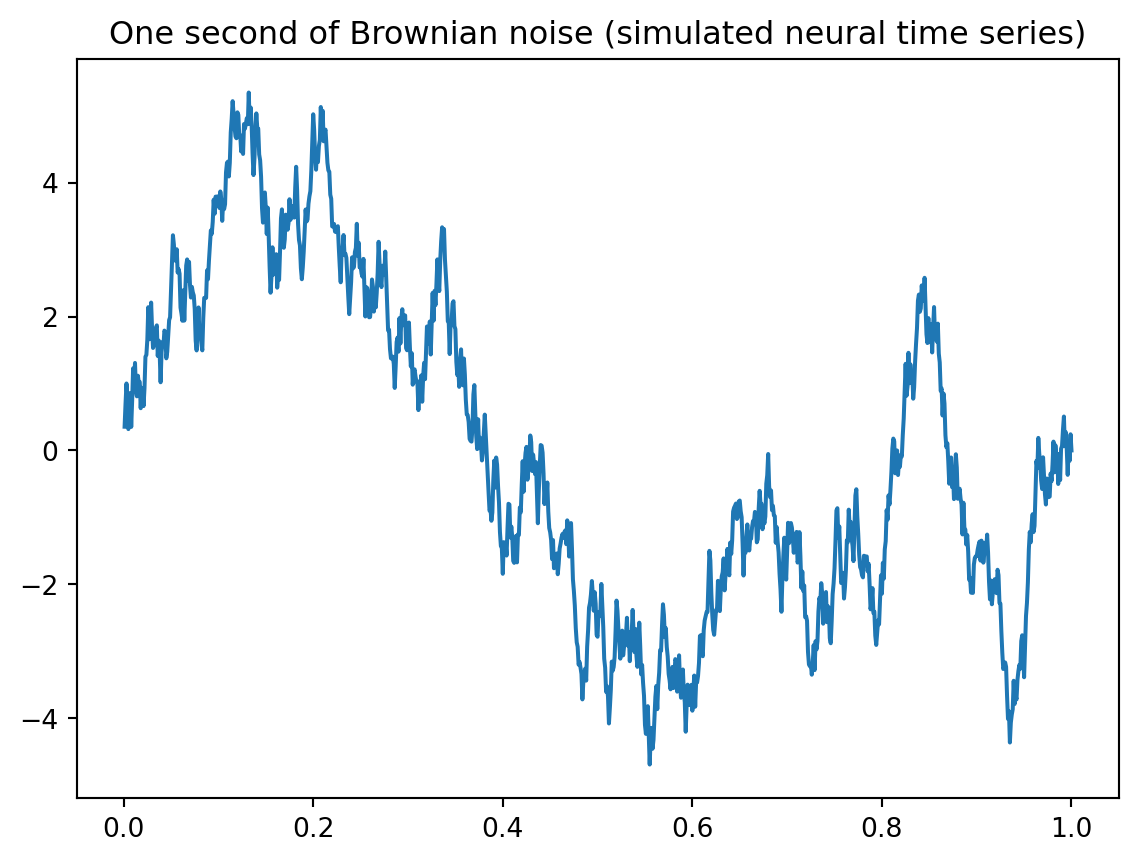

In [2]:
# np.random.seed(0)
time = np.linspace(0.001,1, 1000) # one second of discrete time, sampled at 1000 Hz

# set random number generator, for reproducibility

seed = 13 # set seed for reproducibility
temp = np.random.default_rng(seed=seed).uniform(0,1,1000)-0.5  # zero-centered white noise
#temp = temp*3.0e-10 # scale the white noise if needed

# If ``type == 'constant'``, only the mean of `data` is subtracted. #temp - np.mean(temp)
temp = sig.detrend(temp, type='linear',overwrite_data=True) 

#temp=np.random.uniform(low=0.0, high=1.0, size=(1000))-0.5 # zero-centered white noise
brownsig = np.cumsum(temp) # Brownian noise is the cumulative sum of white noise
brownsig = brownsig - np.mean(brownsig) # zero-centered Brownian noise


plt.plot(time,brownsig)
plt.title('One second of Brownian noise (simulated neural time series)')

In [3]:
#Now we make a simple signal, to be added to the brownian noise.
Sin10Hz = np.sin(2 * np.pi * time * 10) *3

#We start by making a discrete time vector, at which the signal will be sampled. 
time = np.linspace(0.001,1, 1000) # one second of discrete time, sampled at 1000 Hz

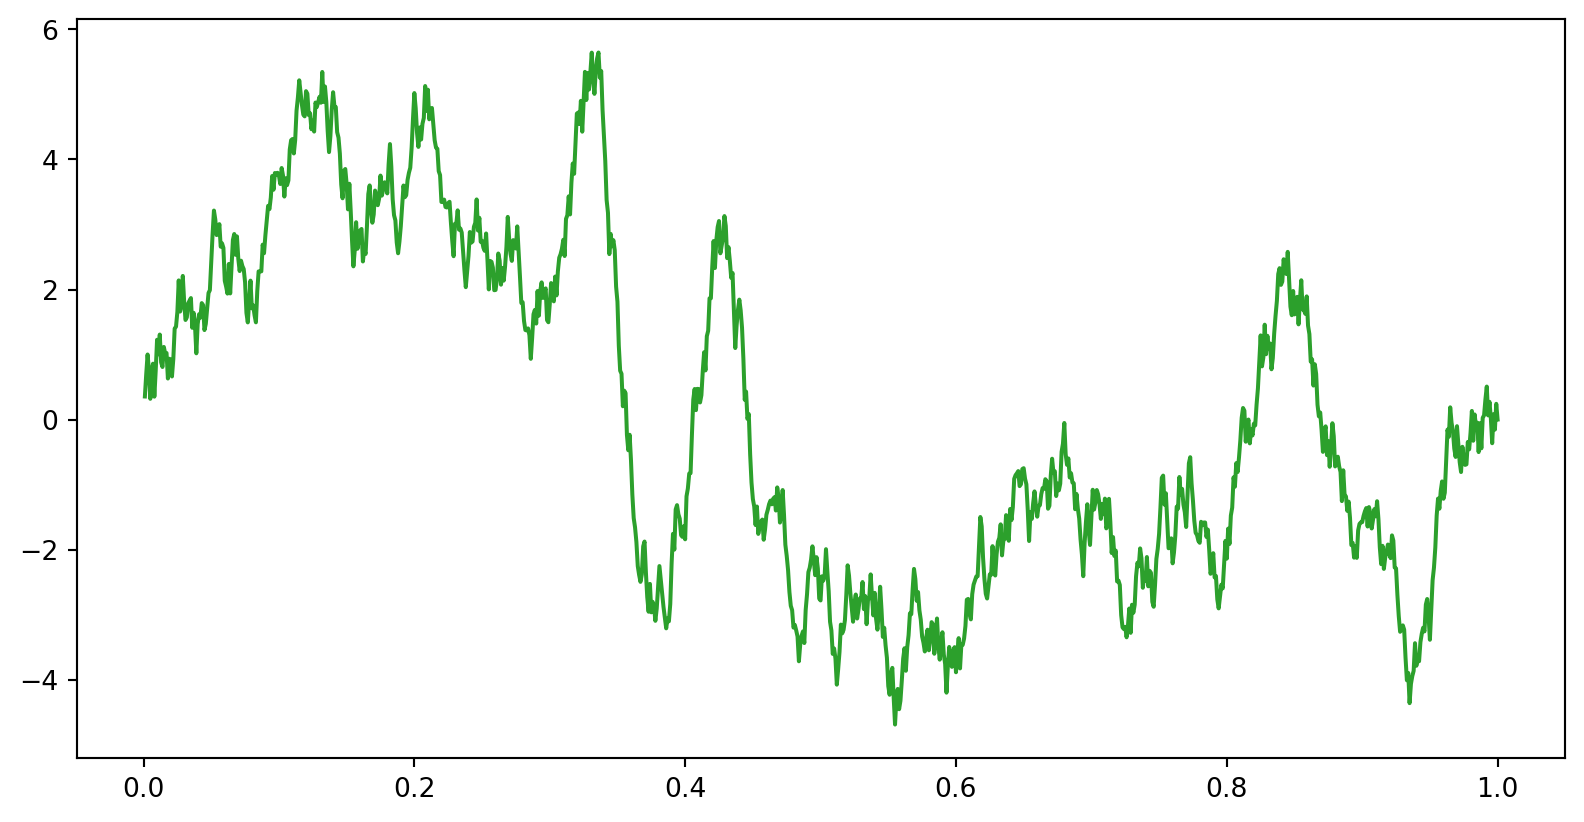

In [4]:
plt.figure(figsize=(10,5))
addsig = np.zeros(1000) # initialize the signal vector
addsig[300:450] = Sin10Hz[300:450] # add the 10 Hz sine wave to the signal vector
data1 = brownsig + addsig
plt.plot(time, data1,lw=1.5,color='C2',label='10 Hz Segment 3µV(0.3 to 0.45)')

now, we make a time series of Brownian noise (biorealistic) time series not unlike EEG/LFP, representing one trial of neural mass data

Text(0.5, 1.0, 'One second of Brownian noise added with a 10 Hz segment')

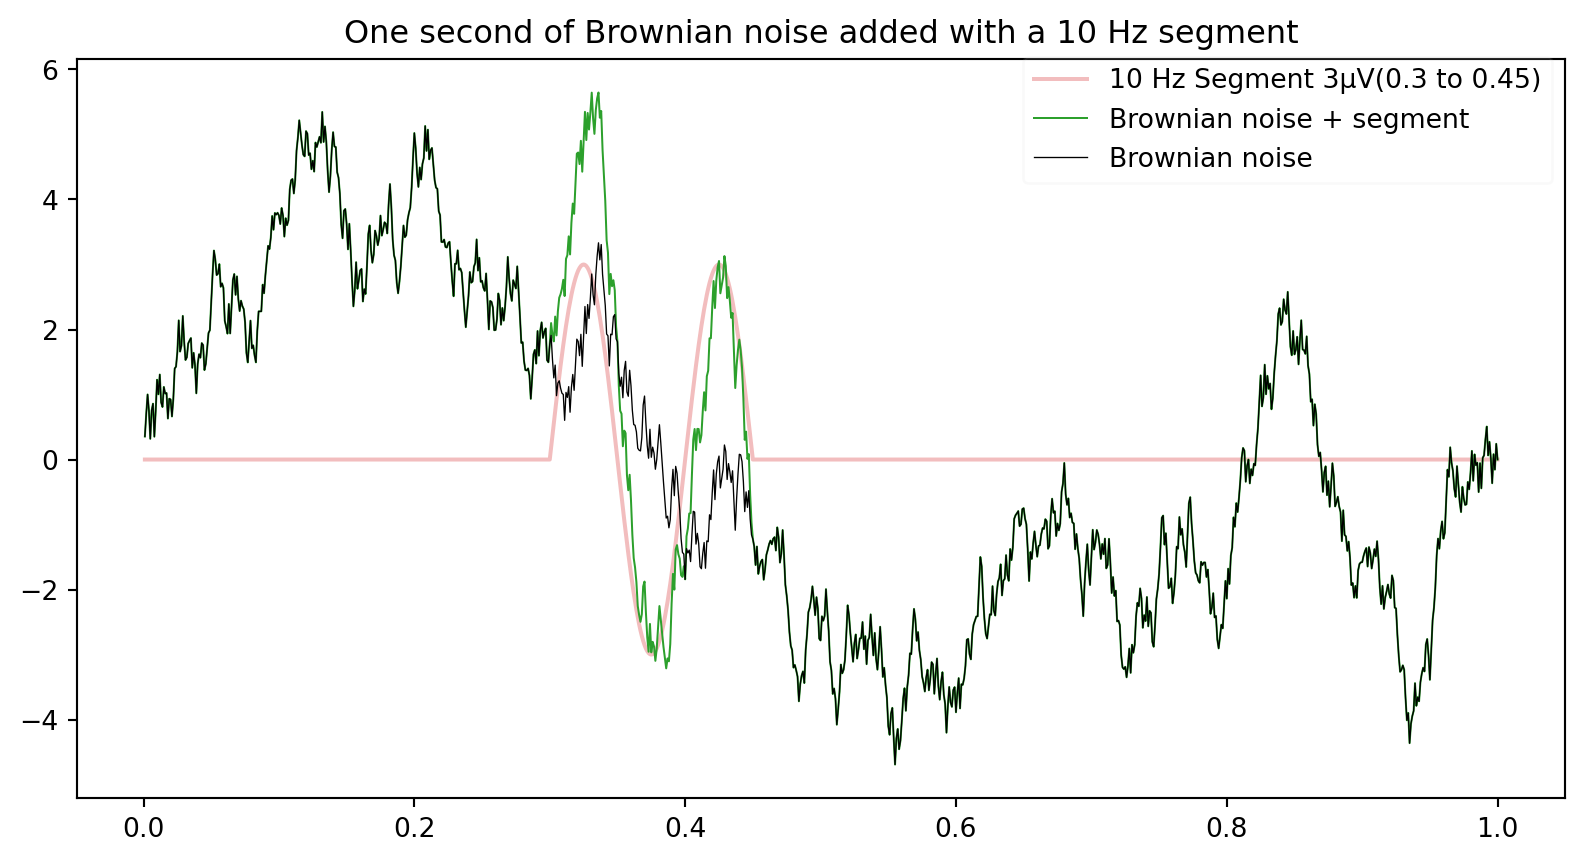

In [5]:
plt.figure(figsize=(10,5))
addsig = np.zeros(1000) # initialize the signal vector
addsig[300:450] = Sin10Hz[300:450] # add the 10 Hz sine wave to the signal vector
data1 = brownsig + addsig
plt.plot(time, addsig,lw=1.5,alpha=0.3,color='C3',label='10 Hz Segment 3µV(0.3 to 0.45)')
plt.plot(time, data1,ls='-',lw=0.75,color='C2',label='Brownian noise + segment')
plt.plot(time, brownsig,lw=0.5,color='k',alpha=1,label='Brownian noise')
plt.legend(loc='upper right',bbox_to_anchor=(1, 1.02),framealpha=0.1)
plt.title('One second of Brownian noise added with a 10 Hz segment')


Now we need a kernel, let's take our added signal and see if we find it! 

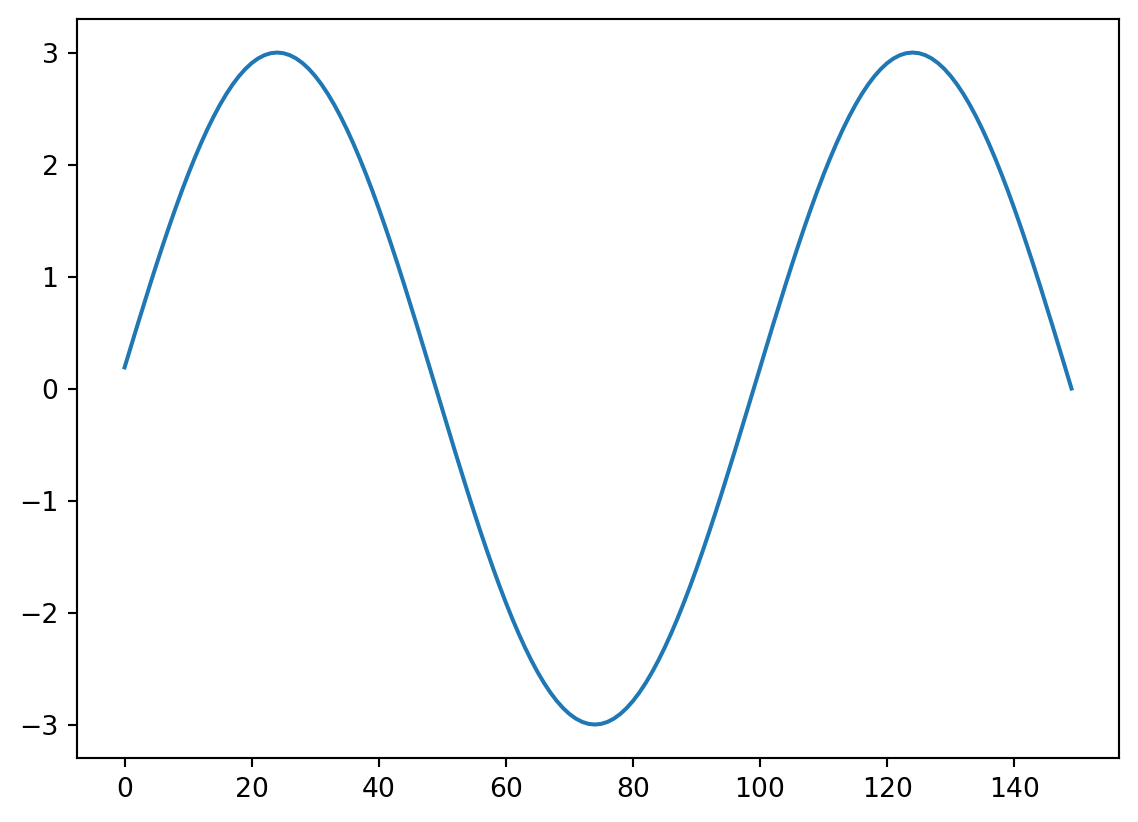

In [6]:
kernel=Sin10Hz[300:450]
kernlength = len(kernel)
plt.plot(kernel)

Now the convolution. let's do it step by step first, by using the dot product 

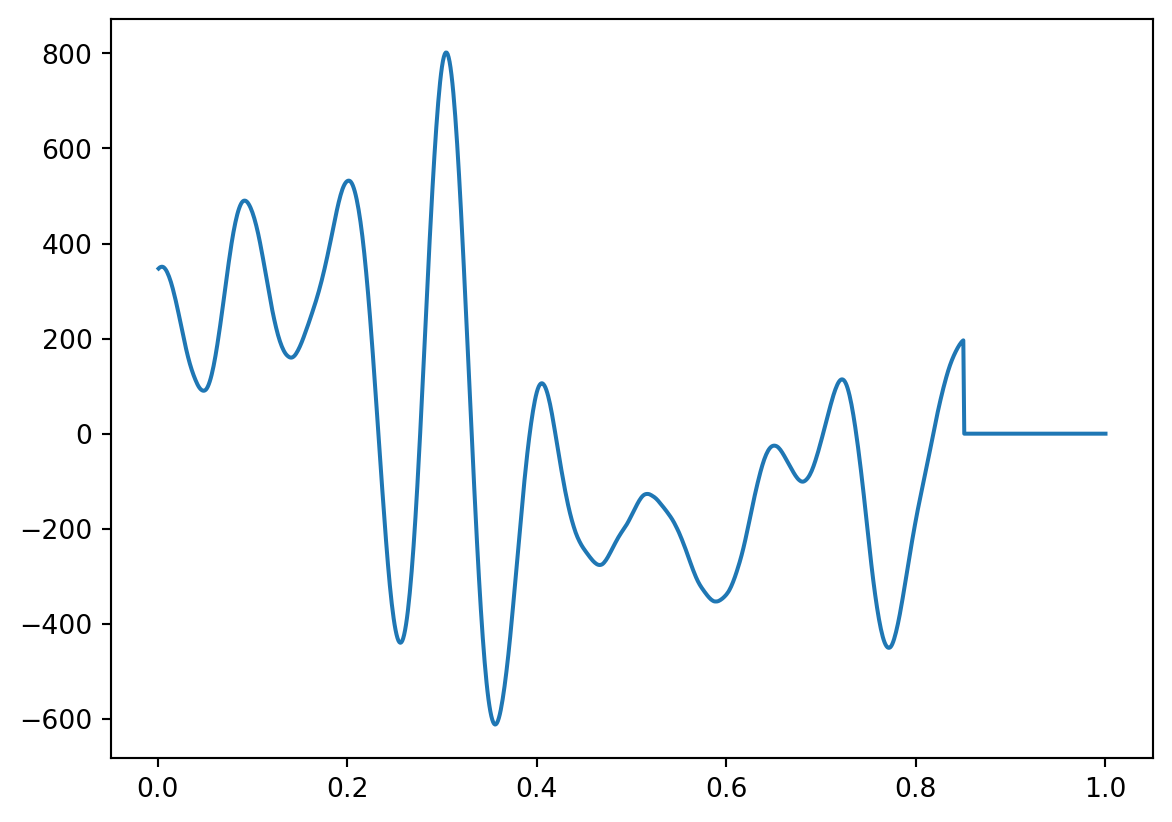

In [7]:
convbyhand=np.zeros(len(data1))
for i in range(0, len(data1)-kernlength):
    convbyhand[i] = np.dot(data1[i:i+kernlength], kernel.T) #the inner product of the kernel, shifted across the data
plt.plot(time,convbyhand)

851


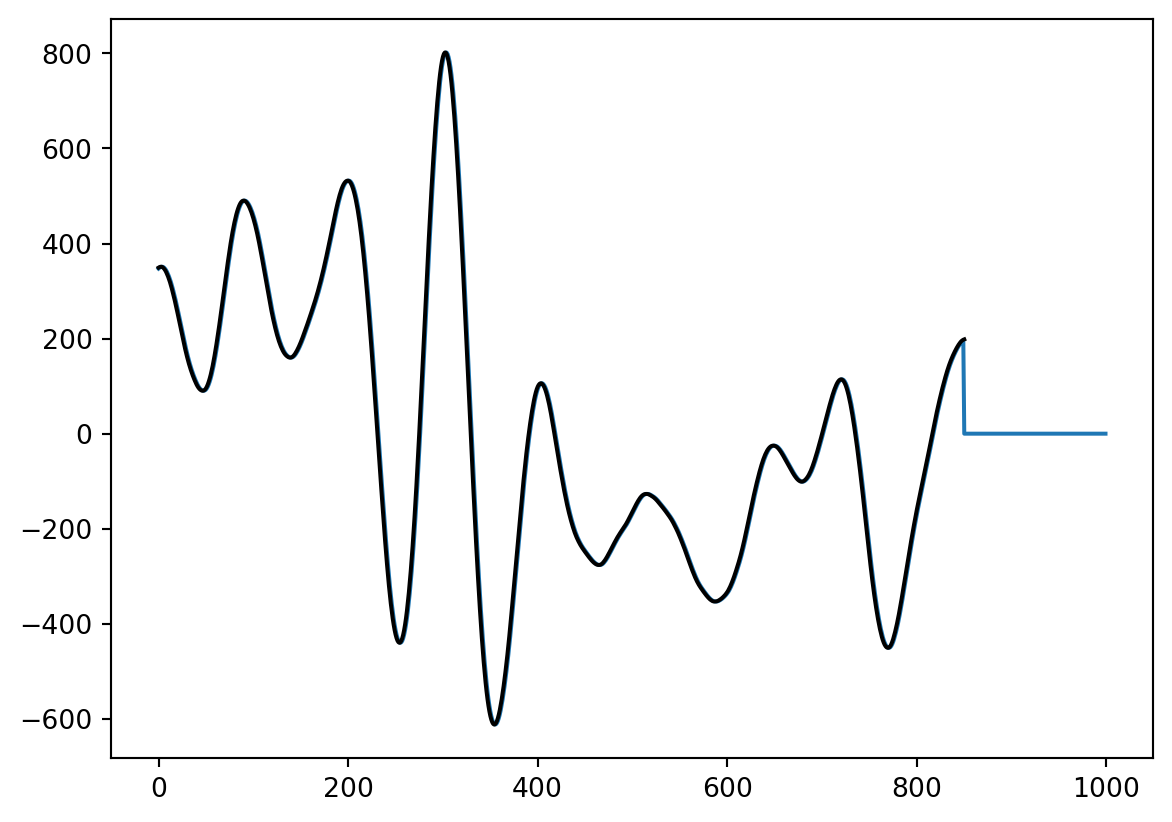

In [8]:
# convbuilt=sig.convolve(data1,kernel,mode='full',method='direct')
# print(len(convbuilt))
# convbuilt=sig.convolve(data1,kernel,mode='same',method='direct')
#print(len(convbuilt))

#valid mode returns only the part of the convolution that is computed without the zero-padded edges
convbuilt=sig.convolve(data1,kernel,mode='valid',method='direct') 
print(len(convbuilt))
plt.plot(convbyhand)
plt.plot(convbuilt,'k')

In [9]:
# for x = 1:size(data1,2)-kernlength
#  convbyhand(x) = data1(x:x+kernlength-1)*kernel'; % the inner product of the kernel, shifted
# end
# plot(time(1:end-kernlength), convbyhand)

compare this with the built-in convolution function

In [10]:

# convbuilt = conv(data1, kernel, 'valid');
# figure
# plot(time(1:end-kernlength), convbyhand), pause(2)
# hold on 
# plot(time(1:end-kernlength), convbuilt(2:end))


not what you expected ? what happened? let's visualize this in more detail. we run the code above again, and visualize the convolution and the moving kernel. 


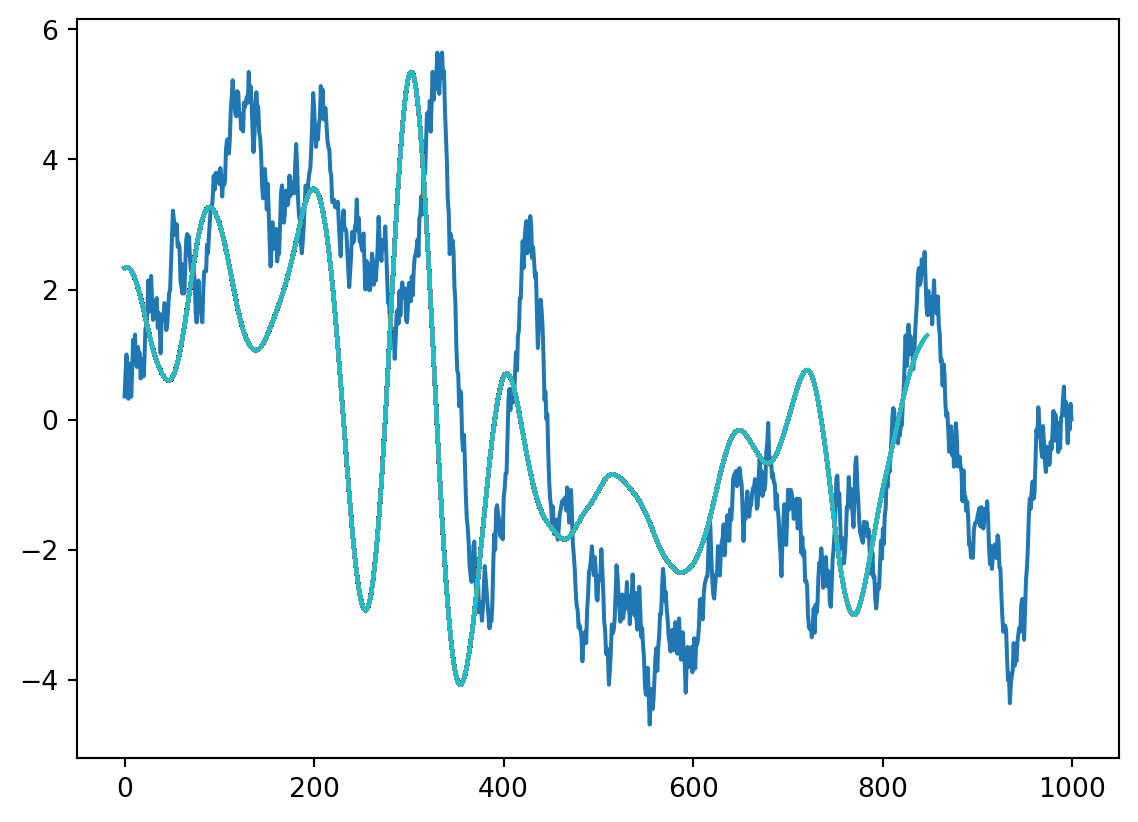

In [11]:
plt.figure()
plt.plot(data1)

for x in range(1, len(data1)-kernlength):
    convbyhand[x] = np.dot(data1[x:x+kernlength], kernel) #the inner product of the kernel, shifted across the data
    plt.plot(convbyhand[1:x]/150) #divide by length of kernel to keep same scale as data



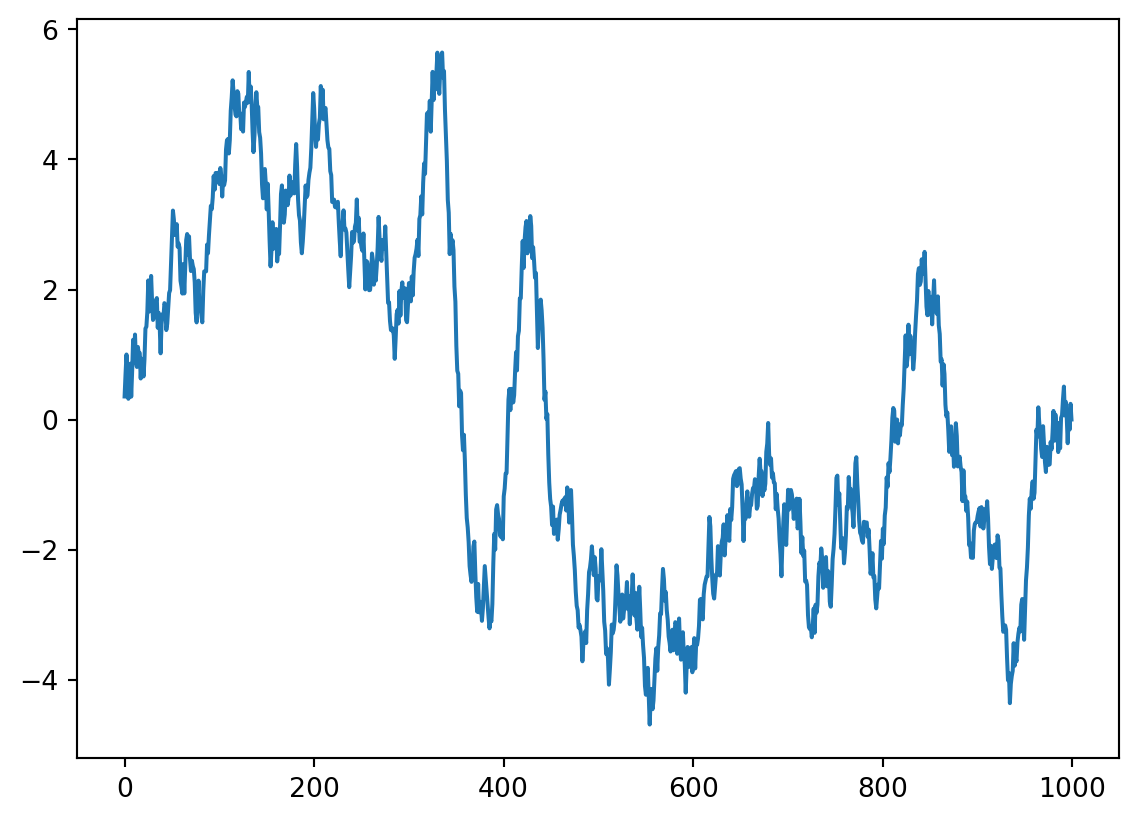

In [12]:
plt.plot(data1)

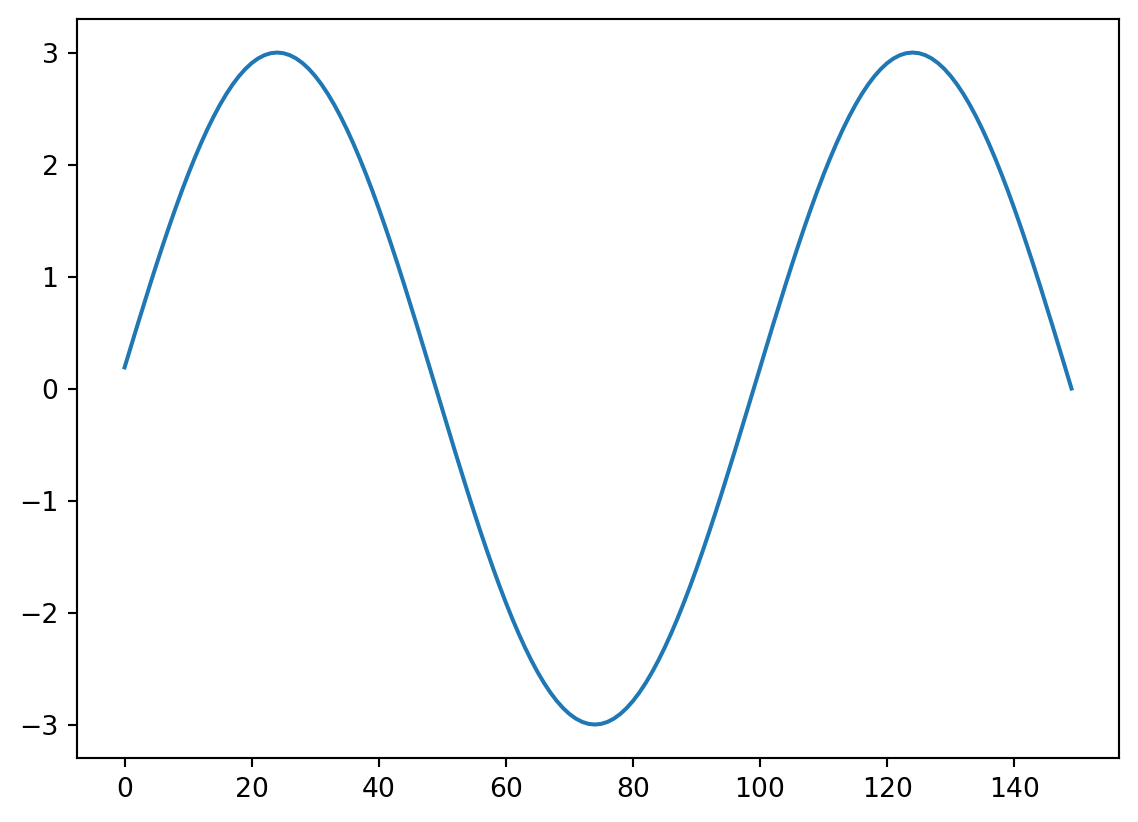

In [13]:
plt.plot(kernel)

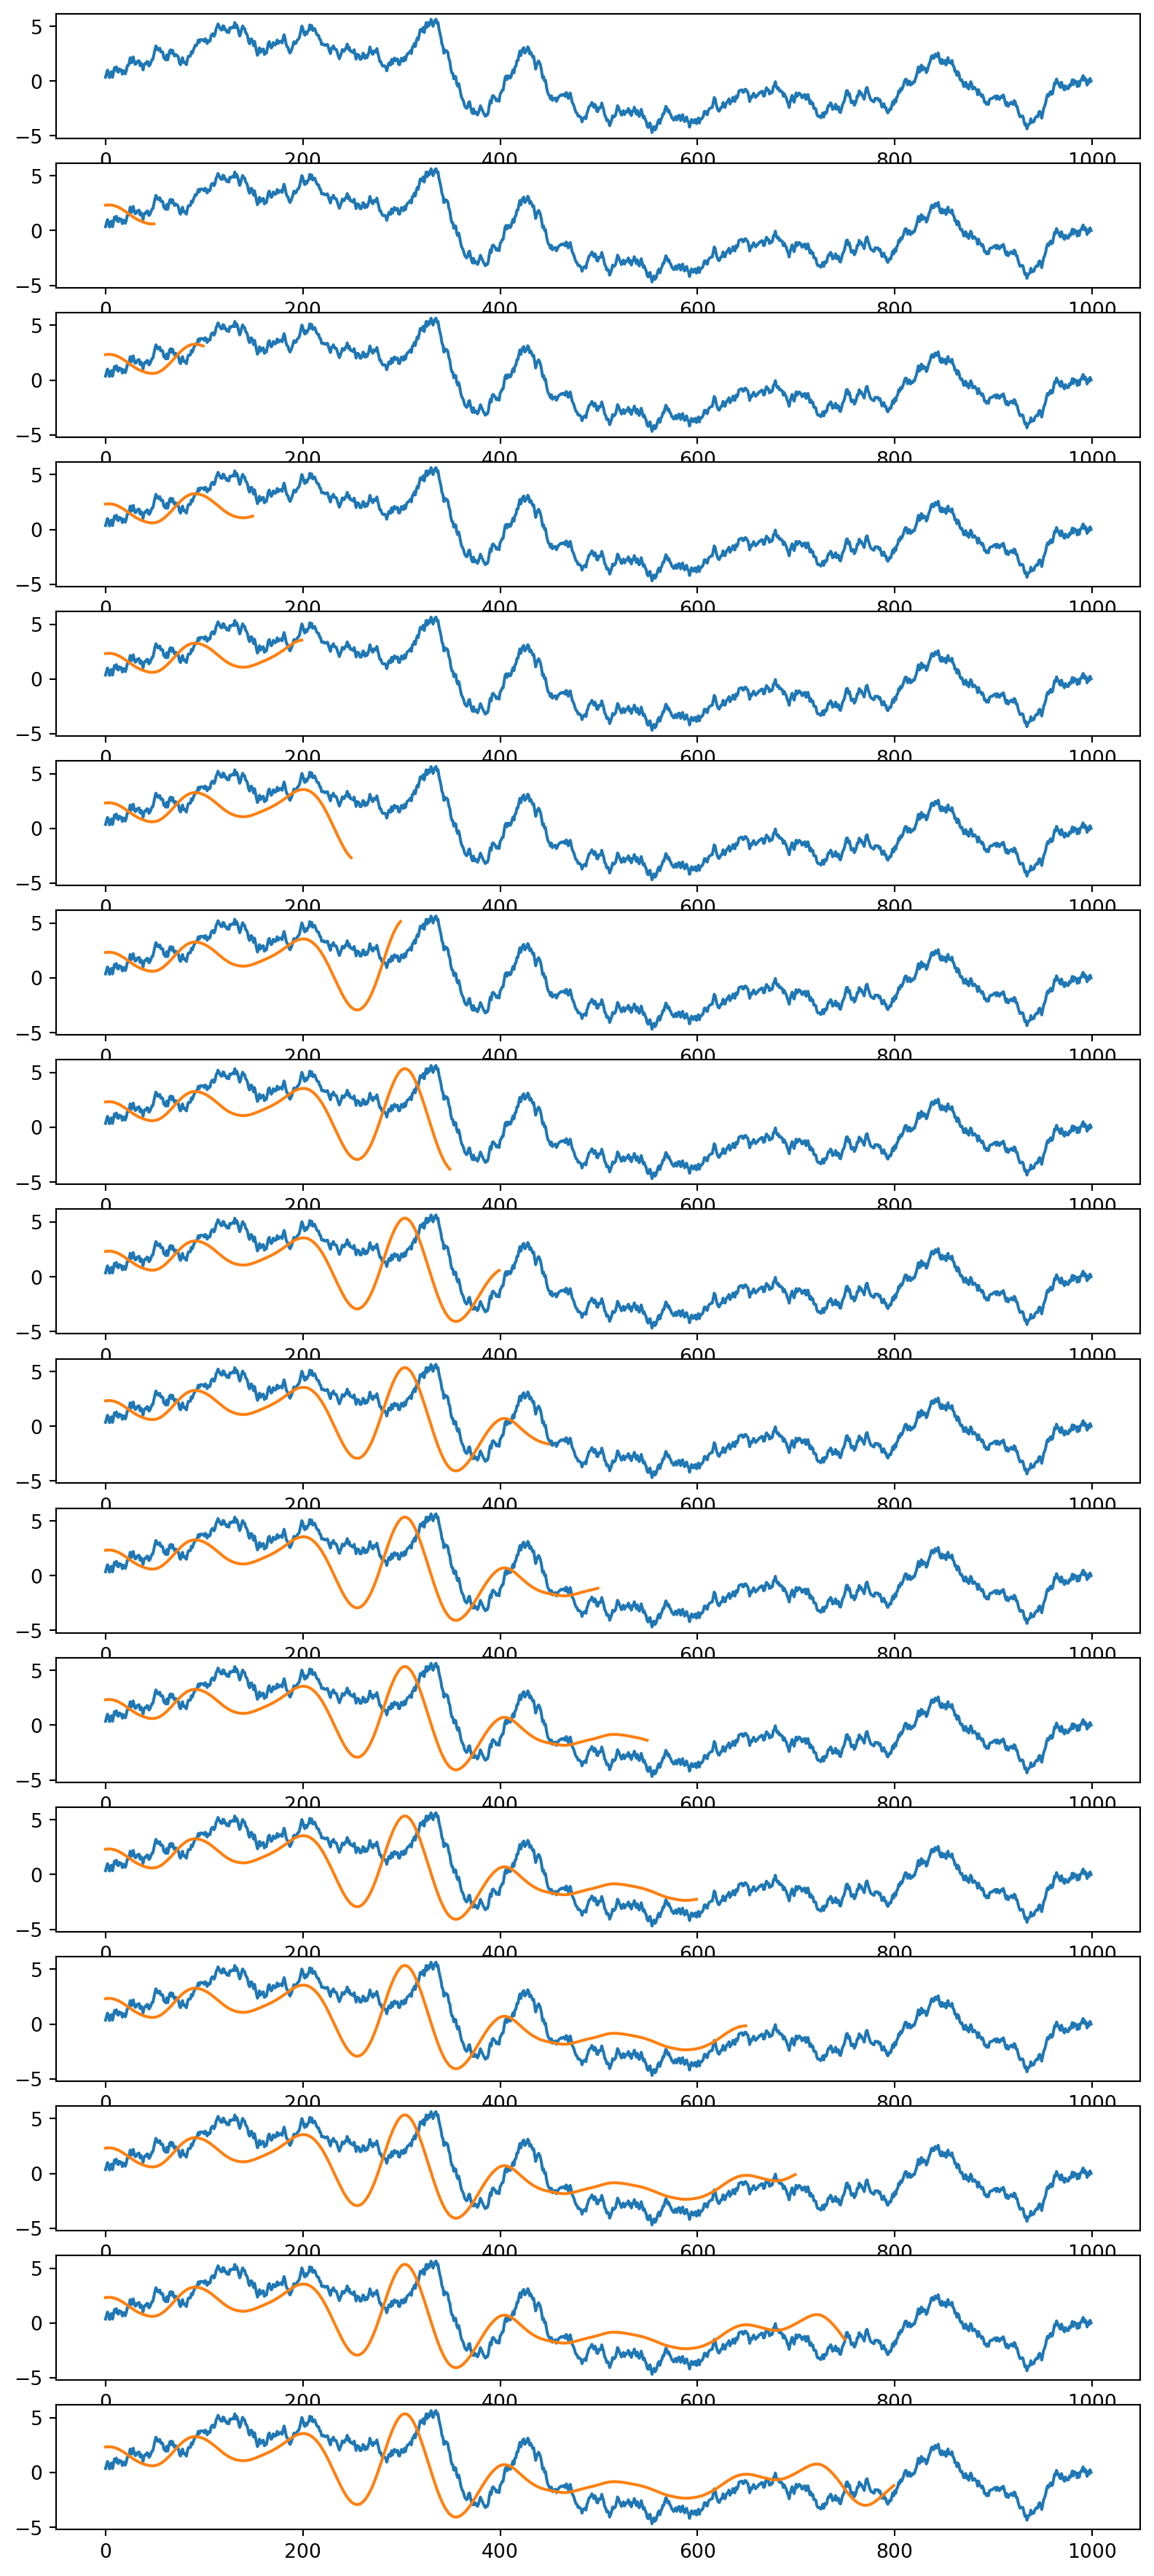

In [14]:
plt.figure(figsize=(10,40))
for ix,x in enumerate(np.arange(0, len(data1)-kernlength,50)):
    plt.subplot(29,1,ix+1)
    plt.plot(data1)
    convbyhand[x] = np.dot(data1[x:x+kernlength], kernel) #the inner product of the kernel, shifted across the data
    plt.plot(convbyhand[0:x]/150) #divide by length of kernel to keep same scale as data

    #plt.ylim(-10, 10)
    #plt.pause(0.01)

It works as adverized but maybe this is not what we need in many situations! we will talk about this next, in the context of Discrete Fourier Transform. 


Appendix: Convolution using Fourier Transform

In [15]:
import scipy.fft as fft
# Initialize two signals with arbitrary length
n, m = 5, 7
convolution_length = n+m-1

u = np.random.randint(0, 255, n)
v = np.random.randint(0, 255, m)

# Convolve the two signals
cv = sig.convolve(u, v)
assert cv.shape[0] == convolution_length

# Now, apply the Convolution Theorem. 
## Copy and pad signal. Padding is necessary to match the convolution length.
vv = v.copy()
vv.resize(n+m-1, refcheck=False)

uu = u.copy()
uu.resize(n+m-1, refcheck=False)

# Compute FFT
fu = fft.fft(uu)
fv = fft.fft(vv)

# Inverse FFT of frequency signal
fcv = fft.ifft(fu * fv)

# Does the inverse transform of the product of the Fourier transforms of the signals equal the convolution of the two signals?
assert np.allclose(fcv, cv)